In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

from argparse import Namespace
import os
import collections
from collections import Counter

import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
##### 'TRAIN' a new model or 'LOAD' an existing model 
get_model = 'TRAIN'

# @@@@@ 0. Settings

In [3]:
args = Namespace(
    # Training or loading
    get_model   = get_model,
    
    # Data and Path information
    input_path  = os.getcwd(),
    output_path = os.getcwd()+'/OUTPUT/',
    save_model_name = 'surname_elman_model.pth',
    
    # nn.Embedding 
    embedding_dim   = 100,
    
    # nn.RNNCell
    rnn_hidden_size = 64,
    
    # Training hyperparameters
    learning_rate   = 0.001,
    batch_size      = 64,
    num_epochs      = 100,
    early_stopping_criteria = 5,
    device          = 'cpu'
)


# @@@@@ 1. Data Preparation
## The data preparation part is to perform a text-to-vectorized-minibatch pipeline: converting text inputs to vectorized minibatches.
- ### Step 1: Creating a Vocabulary - mapping each token (characters in the context of surnames) in the surname data to a numerical version of itself.
- ### Step 2: Vectorization - going from a text dataset to a vector. The Vectorizer turns different surnames to vectors of integers with the same length.
- ### Step 3: Group the vectorized data points into batches.

## 1.1 - Read Data
### **Train partition**: a dataset to derive the model parameters
### **Valid partition**: a dataset for selecting among hyperparameters and making modeling decisions
### **Test partition**: a dataset for final evaluation and reporting

In [4]:
df_all = pd.read_csv('surnames_with_splits.csv')
df_all.sample(5)

,nationality,nationality_index,split,surname
4129,English,12,train,Mcneill
5385,English,12,test,Mcnaught
3642,English,12,train,Pickering
9851,Russian,13,train,Teterin
5820,German,9,train,Schenck


In [5]:
Crosstab = pd.crosstab(df_all['nationality'], df_all['split'])
Crosstab['total'] = Crosstab.sum(axis=1)
Crosstab.loc['Total'] = Crosstab.sum(axis=0)
Crosstab

split,test,train,val,total
nationality,,,,
Arabic,241,1122,240,1603
Chinese,33,154,33,220
Czech,63,289,62,414
Dutch,36,165,35,236
English,447,2080,445,2972
French,35,160,34,229
German,87,403,86,576
Greek,24,109,23,156
Irish,28,128,27,183


## 1.2 - The Vocabulary/SequenceVocabulary class
### [A walkthrough of Vocabulary](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vocabulary.ipynb)
### [A walkthrough of SequenceVocabulary](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_SequenceVocabulary.ipynb)
### - The Vocabulary class will be used to create the vocabulary of nationalities, and the SequenceVocabulary class will be used to create the vocabulary of surnames. These objects will be used in the Vectorization step (discussed next). 
### - The Vocabulary create a mapping between the tokens and integers, in terms of dictionaries. To make this mapping reversible, create two dictionaries, one is from-token-to-index, one is from-index-to-token. Then encapsulate this mapping (bijection) into a Vocabulary/SequenceVocabulary class.
### - By using the UNK token, we can handle tokens at test time that were never seen in training. There is one additional optional step for creating the vocabulary - couting the tokens appeared in the "context" and "target" columns, and ONLY add frequent tokens that apprear more than a pre-specified number to the Vocabulary, while treat infrequent tokens as UNK.
### - SequenceVocabulary is a subclass of the standard Vocabulary class that bundles four special tokens used for sequence data: the UNK token, the MASK token, the BEGIN-OF-SEQUENCE token, and the END-OF-SEQUENCE token. 
#### (1) MASK tokens: serves as a sentinel for Embedding layers and loss calculations when we have sequences of variable length.
#### (2) BEGIN-OF-SEQUENCE and END-OF-SEQUENCE tokens: give the neural network hints about the sequence boundaries.
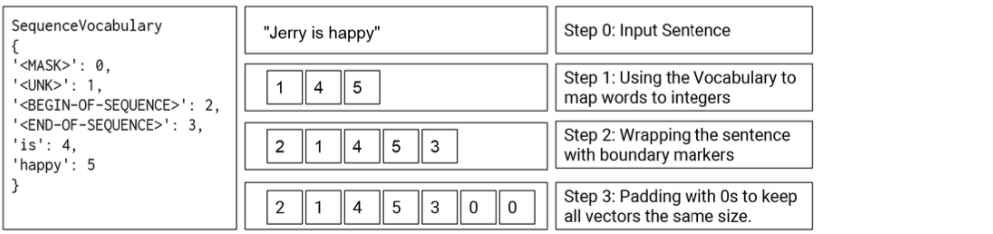
### - Expected behaviors:
#### (1) add_token(): to add new tokens to the Vocabulary
#### (2) lookup_token(): to retrieve the index for a token
#### (3) lookup_index(): to retrieve the token corresponding to a specific index.

In [6]:
class Vocabulary(object):

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """
        if token_to_idx is None:
            token_to_idx = {}
            
        self._token_to_idx = token_to_idx
        
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            ### add a new element to _token_to_idx
            self._token_to_idx[token] = index
            ### add a new element to _idx_to_token
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, 
                 token_to_idx    = None, 
                 unk_token       = "<UNK>",
                 mask_token      = "<MASK>", 
                 begin_seq_token = "<BEGIN>",
                 end_seq_token   = "<END>"):
        
        
        super().__init__(token_to_idx)
        """
        The follow attributes have been defined in the Vocabulary class:
            - ._token_to_idx
            - ._idx_to_token
        """

        self._mask_token      = mask_token      # default: "<MASK>"
        self._unk_token       = unk_token       # default: "<UNK>"
        self._begin_seq_token = begin_seq_token # default: "<BEGIN>"
        self._end_seq_token   = end_seq_token   # default: "<END>"

        self.mask_index       = self.add_token(self._mask_token)      # return 0
        self.unk_index        = self.add_token(self._unk_token)       # return 1
        self.begin_seq_index  = self.add_token(self._begin_seq_token) # return 2
        self.end_seq_index    = self.add_token(self._end_seq_token)   # return 3
        
    
    ### Overriding the self.lookup_token() method
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

## 1.3 - Vectorization
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vectorizer_tokenID.ipynb)
### - The class method **from_dataframe()** is used to instantiate a SurnameVectorizer object from a dataframe.
### - The SurnameVectorizer encapsulates the nationality vocabulary (nationality_vocab) and the surname vocabulary (surname_vocab).
### - The surname_vocab will be used as the reference for vector representation based on the Token IDs. Each unique token (character in this case) in the final vocabulary is assigned a unique numerical index or ID. In the vector, the i-th number represents the token ID for the i-th character.
### - The class method **vectorize()** is the core functionality of the Vectorizer. It takes as an argument a string representing a surname and returns a vector representation for the surname.

In [8]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab       = surname_vocab
        self.nationality_vocab   = nationality_vocab
         
    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab      = SequenceVocabulary()
        nationality_vocab  = Vocabulary()
        
        ########## Add tokens to surname_vocab and nationality_vocab
        for index, row in surname_df.iterrows():

            # Add tokens(characters) to surname_vocab
            for letter in row.surname:
                surname_vocab.add_token(letter)
            # Add tokens(words) to nationality_vocab
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            surname (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        ### set the first index to be begin_seq_index=2 (defined in SequenceVocabulary)
        indices = [self.surname_vocab.begin_seq_index]
        
        ### adding the indeces for the surname after the first index
        indices.extend(self.surname_vocab.lookup_token(token) 
                       for token in surname)
        
        ### set the last index to be end_seq_index=3 (defined in SequenceVocabulary)
        indices.append(self.surname_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.surname_vocab.mask_index
        
        return out_vector, len(indices)

## 1.4 - Batches
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/batch_generator.ipynb)

### - Group the vectorized data points into batches. 
### - The grouping is conducted throught the built in class **[DataLoader](https://pytorch.org/docs/stable/data.html)** in PyTorch. 
### - The class SurnameDataset inherits from the [**Dataset**](https://pytorch.org/vision/0.16/datasets.html) class. Instances of the derived class **SurnameDataset** can then be used with data loading tools like **DataLoader()** for efficient batch loading during model training.
### - The methods \_\_len\_\_(), and \_\_getitem\_\_() are defined in class **SurnameDataset** - these magic functions are expected by the **DataLoader()**. An object equipped with \_\_len\_\_() can be passed to the len() Python build-in function. For objects equipped with \_\_getitem\_\_() we can use the standard subscript for indexing tuples and lists to access individual items. 
### - The **DataLoader()** function utilizes the return results of the \_\_getitem\_\_() method in the dataset to construct batches of data. In each iteration, **DataLoader()** calls the \_\_getitem\_\_() method of the dataset to retrieve a sample, and then combines these samples into a batch. 
### - In **DataLoader()**, the \_\_getitem\_\_() method uses an index generated by the **Sampler** object. The **Sampler** is responsible for determining the indices of samples in each batch. This index may be generated sequentially or randomly, depending on the setting of the shuffle parameter.
### - Define a batch generator function that wraps the DataLoader and switch the data between the CPU and the GPU.

In [9]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        self.surname_df  = surname_df
        self._vectorizer = vectorizer
        
        ### SurnameVectorizer.vectorize() with be used with the parameter 
        ### vector_length = self._max_seq_length (the max length among all comments),
        ### so that the vectors for different rows will have the same length.
        ### +1 if only using begin_seq, +2 if using both begin and end seq tokens
        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        
        self.train_df    = self.surname_df[self.surname_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.surname_df[self.surname_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val'  : (self.val_df, self.validation_size),
                             'test' : (self.test_df, self.test_size)}
        self.set_split('train')
        
        # Class weights - Assign a weight to each class that inversely proportional to its frequency.
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_csv_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer   = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,surname_df):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_df: dataset
        Returns:
            an instance of SurnameDataset
        """
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer   = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        
        row = self._target_df.iloc[index]

        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data'   : surname_vector,
                'y_target' : nationality_index, 
                'x_length' : vec_length}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

### Generator Function

In [10]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device='cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset    = dataset, 
                            batch_size = batch_size,
                            shuffle    = shuffle, 
                            drop_last  = drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### An example of one data batch

In [11]:
df_sample      = df_all.sample(100,random_state=100)
dataset_sample = SurnameDataset.load_df_and_make_vectorizer(df_sample)
batch_size     = 10
shuffle        = True
drop_last      = True
dataloader     = DataLoader(dataset=dataset_sample, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
one_batch = next(iter(dataloader))
print('x_data in one batch')
print(one_batch['x_data'])
print('size of x_data:', one_batch['x_data'].shape)
print('-' * 60)
print('y_target in one batch')
print(one_batch['y_target'])
print('size of y_data:', one_batch['y_target'].shape)
print('-' * 60)
print('x_length in one batch')
print(one_batch['x_length'])

x_data in one batch
tensor([[ 2, 34, 23,  8, 30, 18,  5, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 39,  8, 15, 24, 23,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 38, 23, 14,  6,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 31,  5, 24, 13, 18,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 40, 14, 35, 24,  6, 23, 22, 18,  3,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 46,  6,  8, 18, 35,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 43,  5, 25,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 10,  8, 30, 30, 18,  9, 37,  8, 18,  3,  0,  0,  0,  0,  0,  0],
        [ 2, 44,  5, 45, 14, 18, 19,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 40,  8, 15, 48, 23,  6, 35,  3,  0,  0,  0,  0,  0,  0,  0,  0]])
size of x_data: torch.Size([10, 17])
------------------------------------------------------------
y_target in one batch
tensor([ 7,  1,  0,  0,  3,  6,  0,  3, 10,  3])
size of y_data: torch.Size([10

### An example in one_batch

In [12]:
surname_index = one_batch['x_data'][0]
print("surname_index:", surname_index)
surname_text  = "" 
for i in surname_index.tolist():
    if i > 3:
        surname_text+=dataset_sample._vectorizer.surname_vocab.lookup_index(i)
print("surname_text:", surname_text)

surname_index: tensor([ 2, 34, 23,  8, 30, 18,  5, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0])
surname_text: Coilean


In [13]:
nationality_index = one_batch['y_target'][0]
print("nationality_index:", nationality_index)
nationality_text = dataset_sample._vectorizer.nationality_vocab.\
                   lookup_index(nationality_index.tolist())
print("nationality_text:", nationality_text)

nationality_index: tensor(7)
nationality_text: Irish


### The dimention of x_data is [batch_size, SurnameDataset._max_seq_length]

In [14]:
print("checking")
print(f"batch_size: {batch_size}")
print(f"SurnameDataset._max_seq_length: {dataset_sample._max_seq_length}")
print("-"*60)
df_temp = df_all.copy()
df_temp['surname_len'] = df_temp.surname.apply(len)
print("Rows for the five longest suranmes")
df_temp.sort_values(by='surname_len', ascending=False).head(5)

checking
batch_size: 10
SurnameDataset._max_seq_length: 17
------------------------------------------------------------
Rows for the five longest suranmes


,nationality,nationality_index,split,surname,surname_len
6514,Irish,1,train,Maceachthighearna,17
6304,Greek,4,train,Chrysanthopoulos,16
8613,Russian,13,train,Abdank-Kossovsky,16
2333,Dutch,2,train,Vandroogenbroeck,16
6375,Greek,4,val,Chrysanthopoulos,16


# @@@@@ 2. Model / Optimizer / Loss
## 2.1 - The model (Elman RNN)

### - The **SurnameClassifier** inherits from PyTorch’s **Module**. The classifier has three essential steps: nn.Embedding, a ElmanRNN layer (using [nn.RNNCell](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html)) and two nn.Linear layers.  

### - Details about the Elman RNN layer is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/ElmanRNN.ipynb).
### - Example of training word embeddings: [Learning the Continuous Bag of Words (CBOW) Embeddings](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/MAIN_frankenstein_Embedding.ipynb)

### - In PyTorch, the **nn.Module** class implements the **\_\_call\_\_** method, enabling model instances to be invoked like functions. Calling an instance from nn.Module with a set of arguments ends up calling a method named forward with the same argument. The forward function executes the forward computation, while **\_\_call\_\_** does other important chores before and after calling forward. In general, the correct way to call the module as a function is to use **Classifier(input)**, rather than **Classifier.forward(input)**, although they will produce the same outputs (silient errors, since there are steps not called properly if just using **forward(...)** directly).

### - The output of the ElmanRNN class is a three dimensional tensor—there is a hidden state vector for each data point on the batch dimension and each time step. These vectors represent the hidden state for each character in the surname. Because the goal is to classify each surname, the vector corresponding to the final character position in each surname is extracted.

In [15]:
### Extracting the vector corresponding to the final character position in each surname
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


In [16]:
### Define the ElmanRNN layer, will be called in SurnameClassifier
class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


In [17]:
class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_dim, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            For embedding
            embedding_dim (int)  : The size of the character embeddings
            num_embeddings (int) : The number of characters to embed
                                   len(surname_vocab)
            padding_idx (int)    : The index for the tensor padding
            
            For RNN
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool)   : Informs whether the input tensors will 
                                   have batch or the sequence on the 0th dimension
            For Linear
            num_classes (int)    : The size of the prediction vector 
                                   len(nationality_vocab)
            
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings = num_embeddings,
                                embedding_dim  = embedding_dim,
                                padding_idx    = padding_idx)
        self.rnn = ElmanRNN(input_size   = embedding_dim,
                             hidden_size = rnn_hidden_size,
                             batch_first = batch_first)
        self.fc1 = nn.Linear(in_features = rnn_hidden_size,
                         out_features    = rnn_hidden_size)
        self.fc2 = nn.Linear(in_features = rnn_hidden_size,
                          out_features   = num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

### Define the model 
### - Data: df_all
### - Training hyperparameters (batch_size, device): defined in args

In [18]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)
dataloader = DataLoader(dataset = dataset,
                        batch_size = 128,
                        shuffle = True,
                        drop_last = True)
vectorizer = dataset.get_vectorizer()

n_tokens_in_vocabulary = len(vectorizer.surname_vocab)
n_class                = len(vectorizer.nationality_vocab)
print(f"There are {n_tokens_in_vocabulary} tokens in the surname vocabulary.")
print(f"There are {n_class} classes in the nationality vocabulary.")

There are 80 tokens in the surname vocabulary.
There are 18 classes in the nationality vocabulary.


In [19]:
classifier_temp = SurnameClassifier(embedding_dim   = 4, 
                                    num_embeddings  = len(vectorizer.surname_vocab), 
                                    num_classes     = len(vectorizer.nationality_vocab),
                                    rnn_hidden_size = 3, 
                                    batch_first     = True, 
                                    padding_idx     = 0)

In [20]:
def print_parameters_classifier(classifier, print_shape=True, print_value=True):
    for name, param in classifier.named_parameters():
        if param.requires_grad:
            print(f"Parameter name: {name}")
            if print_shape:
                print(f"Shape: {param.shape}")
                print("-"*100)
            if print_value:
                print(f"Weights: {param.data}")
                print("-"*100)

In [21]:
print_parameters_classifier(classifier_temp,print_shape=True, print_value=False)

Parameter name: emb.weight
Shape: torch.Size([80, 4])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.rnn_cell.weight_ih
Shape: torch.Size([3, 4])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.rnn_cell.weight_hh
Shape: torch.Size([3, 3])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.rnn_cell.bias_ih
Shape: torch.Size([3])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.rnn_cell.bias_hh
Shape: torch.Size([3])
----------------------------------------------------------------------------------------------------
Parameter name: fc1.weight
Shape: torch.Size([3, 3])
----------------------------------------------------------------------------------------------------
Parameter name: fc1.bias
Shape: torch

In [22]:
one_batch = next(iter(dataloader))
print("shape of input:", one_batch['x_data'].shape)
print('-'*80)
print("Outout (using initialized parameters)")
print(classifier_temp(one_batch['x_data'],
                      x_lengths=one_batch['x_length']))
print("Applying softmax")
print(classifier_temp(one_batch['x_data'],
                      x_lengths=one_batch['x_length'],
                      apply_softmax=True))
print("Predicted category (index)")
print(classifier_temp(one_batch['x_data'],
                      x_lengths=one_batch['x_length'],
                      apply_softmax=True).max(dim=1)[1])

shape of input: torch.Size([128, 19])
--------------------------------------------------------------------------------
Outout (using initialized parameters)
tensor([[-0.8737, -0.3678, -0.1446,  ...,  0.1276, -0.4371,  0.5185],
        [-0.6694, -0.3912, -0.0149,  ..., -0.0338, -0.6046,  0.6012],
        [-1.8816, -0.4527,  0.7553,  ...,  0.1462, -1.6497,  1.6172],
        ...,
        [-1.0100, -0.3927, -0.1330,  ...,  0.1497, -0.4875,  0.5533],
        [-0.3902, -0.2324,  0.2036,  ..., -0.0199, -0.6594,  0.7969],
        [-1.2890, -0.4251,  0.4063,  ...,  0.0458, -1.1738,  1.1476]],
       grad_fn=<AddmmBackward0>)
Applying softmax
tensor([[0.0132, 0.0293, 0.0602,  ..., 0.0460, 0.0149, 0.1246],
        [0.0361, 0.0378, 0.0388,  ..., 0.0548, 0.0464, 0.0683],
        [0.0178, 0.0303, 0.0669,  ..., 0.0399, 0.0133, 0.1312],
        ...,
        [0.0471, 0.0419, 0.0427,  ..., 0.0530, 0.0453, 0.0728],
        [0.0293, 0.0368, 0.0551,  ..., 0.0480, 0.0255, 0.1011],
        [0.0216, 0.0352, 0

### Define the formal classifier

In [23]:
classifier = SurnameClassifier(embedding_dim   = args.embedding_dim,
                               num_embeddings  = len(vectorizer.surname_vocab),
                               num_classes     = len(vectorizer.nationality_vocab),
                               rnn_hidden_size = args.rnn_hidden_size,
                               batch_first     = True,
                               padding_idx     = 0)

## 2.2 - The loss function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).
### - As mentioned, the loss function should be appropriate for the activation function.

In [24]:
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

## 2.3 - The optimizer and scheduler
### The initialized state of the classifier
### Using [torch.nn.Module.parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)
#### These are the tensors that the optimizer will get. After calling **model.backward()** the parameters are populated with their grad, and the optimizer then updates their values accordingly during the **optimizer.step()** call.
#### The requires_grad = True argument is telling PyTorch to track the entire family tree of tensors resulting from operations on *parameters*.

In [25]:
classifier

SurnameClassifier(
  (emb): Embedding(80, 100, padding_idx=0)
  (rnn): ElmanRNN(
    (rnn_cell): RNNCell(100, 64)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=18, bias=True)
)

### Define the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer 
#### - the learning rate is set adaptively
#### - it is not sensitive to the scaling of the parameters

In [26]:
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

### Apply a scheduler for adjusting learning rate
### - [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html) provides several methods to adjust the learning rate based on the number of epochs.
### - [torch.optim.lr_scheduler.ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.
### - This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
### - Parameters:
1. **mode(str)**: In "min" mode, lr will be reduced when the quantity monitored has stopped decreasing; in "max" mode it will be reduced when the quantity monitored has stopped increasing. Default: 0.1.
2. **factor(float)**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
3. **patience (int)**: Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
4. **threshold (float)** – Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.

### - A **scheduler.step(val_loss)** method is called at the end of each epoch to execute the update of the learning rate. The parameters “val_loss” represents the loss (or other monitoring metric) computed for the model on the validation set. This loss value is typically used by the scheduler to assess the model's performance on the validation set and update the learning rate accordingly.
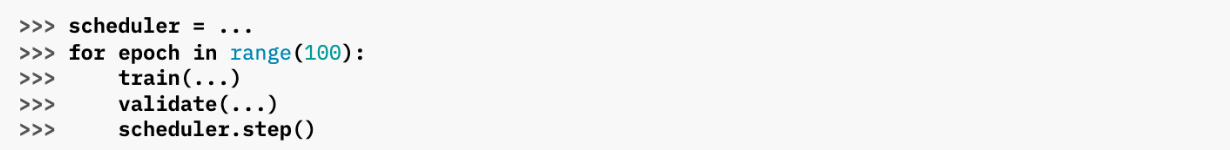

In [27]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                 mode      = 'min', 
                                                 factor    = 0.5,
                                                 patience  = 1)

# @@@@@ 3. Training Routine
## 3.1 - Helper function: tracking the training state

In [28]:
def init_train_state(args):
    train_state_dict = {'stop_early'    : False,
                        'early_stopping_step'     : 0,
                        'early_stopping_best_val' : 1e8,
                        'learning_rate' : args.learning_rate,
                        'epoch_index'   : 0,
                        'train_loss'    : [],
                        'train_acc'     : [],
                        'val_loss'      : [],
                        'val_acc'       : [],
                        'test_loss'     : -1,
                        'test_acc'      : -1,
                        'model_filename': args.save_model_name
                       }
    return train_state_dict

def update_train_state(args, model, train_state):
    """
    Handle the training state updates.
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    Args:
        args:  arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        a new train_state
    """

    # Save the first model
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss increased (not a better model)
        if loss_t >= train_state['early_stopping_best_val']:
            # Update early_stopping_step
            train_state['early_stopping_step'] += 1
        # If loss decreased
        else:
            # Save the best model and update the early_stopping_best_val
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # In the main training loop, if train_state['stop_early']: break
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

## 3.2 - Helper function: compute accurary rate

In [29]:
def compute_accuracy(y_pred, y_target, device):
    y_target = y_target.to(device)

    ##### tensor.max(dim=1): the results include two output tensors (max, max_indices)
    _, y_pred_indices = y_pred.to(device).max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [30]:
##### An example
one_batch = next(iter(dataloader))
classifier(one_batch['x_data']).max(dim=1)

torch.return_types.max(
values=tensor([0.1844, 0.1857, 0.1638, 0.1372, 0.1794, 0.2400, 0.1140, 0.2382, 0.2193,
        0.1564, 0.2430, 0.1807, 0.1127, 0.2153, 0.2227, 0.1635, 0.1627, 0.1423,
        0.0946, 0.2177, 0.1064, 0.1527, 0.2403, 0.1926, 0.2072, 0.1421, 0.1963,
        0.2457, 0.1629, 0.1661, 0.1670, 0.2057, 0.1068, 0.1694, 0.1124, 0.1552,
        0.1240, 0.2398, 0.1061, 0.1971, 0.1858, 0.1465, 0.2227, 0.2202, 0.1877,
        0.1825, 0.1256, 0.1358, 0.1070, 0.1501, 0.1789, 0.1794, 0.1668, 0.0961,
        0.2108, 0.1835, 0.1870, 0.1031, 0.2719, 0.2636, 0.1958, 0.1952, 0.1638,
        0.1574, 0.1569, 0.1428, 0.2211, 0.2030, 0.2257, 0.1777, 0.2088, 0.2198,
        0.1162, 0.1996, 0.1577, 0.1912, 0.1581, 0.1494, 0.1571, 0.1537, 0.1283,
        0.1603, 0.2207, 0.1958, 0.1713, 0.1233, 0.1427, 0.1845, 0.1951, 0.2816,
        0.1104, 0.1329, 0.1901, 0.2506, 0.1408, 0.1694, 0.2182, 0.1518, 0.0832,
        0.2112, 0.1868, 0.1315, 0.1247, 0.1928, 0.1498, 0.1756, 0.2224, 0.2064,
        0

In [31]:
outputs = classifier(one_batch['x_data'])
_, pred = outputs.max(dim=1)  
targets = one_batch['y_target']
print('targets:', targets)
print('-'*80)
print('pred:',pred)
print('-'*80)
print('accurary rate:',compute_accuracy(outputs,targets,device='cpu'))

targets: tensor([ 4, 14,  0,  6, 10,  0,  8,  7,  4, 14,  2,  4, 14,  9,  4,  9,  6,  0,
         6,  6, 14, 14,  8,  2,  4, 15,  1,  0,  4,  8,  4,  4,  4,  8, 14,  4,
        14, 10,  0,  4, 14, 14,  6, 10, 10,  0,  4,  4,  4,  4, 14, 16, 14,  9,
         7,  0,  4, 11,  7, 14,  6,  4,  2,  3,  9,  9,  4,  6,  4, 17,  4,  4,
         6,  4, 14,  4, 14,  4,  0,  5,  7, 10,  4,  4,  0,  4,  0,  3, 14, 14,
         0,  6,  4, 14, 10, 14, 16,  0,  0, 14,  0, 13,  4,  4,  8,  4,  0,  9,
         6, 14,  0, 13,  4,  6, 16, 14,  5,  9,  6, 14,  5, 10,  4, 16,  4, 14,
         4,  6])
--------------------------------------------------------------------------------
pred: tensor([10,  4, 17, 10, 17, 17,  2, 14, 17,  8,  8, 10, 10,  8, 17, 10,  8, 10,
        13, 10,  8, 10, 15, 17,  4, 17,  2,  4,  4, 17, 10,  8,  4, 10,  8, 13,
        13, 10, 10,  0, 10, 10,  2,  4, 10,  2,  1, 10, 17,  4, 17, 10,  4, 10,
        10, 13, 17, 10, 10,  2,  2, 15,  0,  2,  4,  4, 10,  8, 10, 10, 10,  8,
       

## 3.3 - Training loop
### - The training loop updates the model parameters so that it improves over time.
### - The training loop is composed of two loops: an inner loop over batches in the dataset, and an outer loop, which repeats the inner loop a number of times.
### - The inner loop (batch), losses are computed for each batch, and the optimizer is used to update the model parameters.

In [32]:
def print_train_state(train_state):
    print('Train Loss:',round(train_state['train_loss'][-1],5))
    print('Train Accuracy:',round(train_state['train_acc'][-1],5))
    print('Valid Loss:',round(train_state['val_loss'][-1],5))
    print('Valid Accuracy:',round(train_state['val_acc'][-1],5))
    print('early_stopping_best_val:',round(train_state['early_stopping_best_val'],5))
    print('early_stopping_step:',train_state['early_stopping_step'])
    print('stop_early:',train_state['stop_early'])

In [33]:
if args.get_model == 'TRAIN':
    ##### Get an initialized train_state
    train_state = init_train_state(args)
    
    for epoch_index in range(args.num_epochs):
        print('-'*60)
        print(f'Epoch {epoch_index}...')
        train_state['epoch_index'] = epoch_index

        ##################################################
        #####     Iterate over training dataset      #####
        ##################################################
        print('Training Iteration...')

        ##### Create a batch_generator using training data
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size = args.batch_size,
                                           device     = args.device)

        ##### running_loss and running_acc are equivalent to the moving averages of loss and accuracy.
        ##### when the loop ends, a moving average is just an average. 
        ##### In each epoch loop, they are reset to zero before the batch loop.
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “training mode” 
        # makes the model parameters mutable 
        # and enables regularization mechanisms like dropout
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------
            ##### STEP 1. zero the gradients
            # Inside each batch iteration, the optimizer’s gradients are first reset
            # Calling backward (step 4 below) will ACCUMULATE gradients, so if the backward()
            # is called earlier, the new gradient is accumulated on top of the one computed 
            # in previous iterations, which leads to an incorrect value for the gradient.
            # Therefore, use this zero_ method to reset the gradients.
            optimizer.zero_grad()

            ##### STEP 2. compute the output
            y_pred = classifier(x_in      = batch_dict['x_data'],
                                x_lengths = batch_dict['x_length'])

            ##### STEP 3. compute the loss
            loss   = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            # update the moving average of loss, batch by batch
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### STEP 4. use loss to produce gradients (gradients are propagated to each parameter)
            # Calling backward() and the gradients at each leaf is ACCUMULATED, not stored.
            # Note that the loss is the loss in train split. There is no valid_loss.backward()
            # because we don't want to train the model on the validation data. 
            loss.backward()

            ##### STEP 5. use optimizer to update parameters
            # the optimizer uses the propagated gradients to perform parameter updates
            # The value of classifier.parameters(), i.e., params is automatically updated in this step. 
            # In specific, the optimizer looks into params.grad and updates params, by substracting 
            # learning_rate * grad from it. 
            optimizer.step()

            ##### Tracking the accuracy
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     args.device)
            # update the moving average of acc, batch by batch
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (training) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        ##################################################
        #####     Iterate over validation dataset    #####
        ##################################################
        print('Validation Iteration...')

        ##### Create a batch_generator using validation data
        dataset.set_split('val')    
        batch_generator = generate_batches(dataset, 
                                           batch_size = args.batch_size, 
                                           device     = args.device)
        ##### Create new running loss, and running accuracy
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “evaluation mode”
        # makes the model parameters immutable 
        # disables dropout
        # disables computation of the loss and propagation of gradients back to the parameters
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            ##### compute the output
            y_pred = classifier(x_in      = batch_dict['x_data'],
                                x_lengths = batch_dict['x_length'])

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     args.device)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (validation) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        ##### Update the status of Early Stopping and Model Checkpoint
        # Input: the current classifier and current train_state (end of the current epoch loop)
        # Update three items in train_state
        # 1."early_stopping_step" +=1 or reset to 0 (comparing val_loss and early_stopping_best_val)
        # 2."early_stopping_best_val" update to the current val_loss if it is the best model
        # 3."stop_early" if early_stopping_step reaches early_stopping_criteria. If True, break all loops below. 
        # Save a new model if the current model has early_stopping_best_val
        train_state = update_train_state(args = args, model = classifier,
                                         train_state = train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        print('Current lr:', optimizer.param_groups[0]['lr'])

        print_train_state(train_state)

        if train_state['stop_early']:
            break

elif args.get_model == 'LOAD':
    classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = classifier.to(args.device)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.85863
Train Accuracy: 10.19531
Valid Loss: 2.77293
Valid Accuracy: 22.125
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.61701
Train Accuracy: 23.9974
Valid Loss: 2.4578
Valid Accuracy: 27.75
early_stopping_best_val: 2.4578
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.34633
Train Accuracy: 28.63281
Valid Loss: 2.27134
Valid Accuracy: 28.9375
early_stopping_best_val: 2.27134
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 3...
Training Iteration...
Validation 

Validation Iteration...
Current lr: 3.125e-05
Train Loss: 1.47713
Train Accuracy: 44.10156
Valid Loss: 1.80757
Valid Accuracy: 41.5
early_stopping_best_val: 1.79787
early_stopping_step: 2
stop_early: False
------------------------------------------------------------
Epoch 28...
Training Iteration...
Validation Iteration...
Current lr: 3.125e-05
Train Loss: 1.48515
Train Accuracy: 43.38542
Valid Loss: 1.92522
Valid Accuracy: 40.0
early_stopping_best_val: 1.79787
early_stopping_step: 3
stop_early: False
------------------------------------------------------------
Epoch 29...
Training Iteration...
Validation Iteration...
Current lr: 1.5625e-05
Train Loss: 1.47191
Train Accuracy: 44.19271
Valid Loss: 1.84608
Valid Accuracy: 39.9375
early_stopping_best_val: 1.79787
early_stopping_step: 4
stop_early: False
------------------------------------------------------------
Epoch 30...
Training Iteration...
Validation Iteration...
Current lr: 1.5625e-05
Train Loss: 1.49173
Train Accuracy: 43.56771
V

# @@@@@ 4. Evaluation
## 4.1 - Evaluation on Test Data
### A. Weighted Model

In [34]:
classifier = SurnameClassifier(embedding_dim   = args.embedding_dim,
                               num_embeddings  = len(vectorizer.surname_vocab),
                               num_classes     = len(vectorizer.nationality_vocab),
                               rnn_hidden_size = args.rnn_hidden_size,
                               batch_first     = True,
                               padding_idx     = 0)
filename   = args.output_path+'surname_elman_model.pth'
classifier.load_state_dict(torch.load(filename))
classifier = classifier.to(args.device)

loss_func  = nn.CrossEntropyLoss(dataset.class_weights)

##### Create a batch_generator using test data
# The test set should be run as little as possible
# Avoid make a new model decision based on the evaluation on test data
# Otherwise the model might be biased toward the test data, and the test data will 
# become meaningless as an measure of truly held-out data.
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc  = 0.0

##### Indicate that the model is in “evaluation mode”
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(batch_dict['x_data'],
                        x_lengths=batch_dict['x_length'])

    # compute the loss
    loss   = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print("Test loss: {:.5f}".format(running_loss))
print("Test Accuracy: {:.5f}".format(running_acc))

Test loss: 1.92747
Test Accuracy: 42.25000


### 4.2 Generation a prediction for a given surname

In [35]:
surnames = {
    'Smith': 'English',
    'Yamamoto': 'Japanese',
    'Dubois': 'French',
    'Rossi': 'Italian',
    'Zhang':  'Chinese',
    'Petrov':  'Russian' ,
    'Kowalski': 'Polish',
    'Park': 'Korean'
 }

In [36]:
def predict_surname(surname,
                    classifier,
                    device, 
                    vectorizer,
                    top_k):
    """Predict the nationality of a surname
    
    Args:
        surname (str): the text of the surname
        classifier (SurnameClassifier): the trained model
        device: device
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        top_k: specify the k in “top-k”
    """
    
    classifier         = classifier.to(device)
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length         = torch.tensor([vec_length], dtype=torch.int64)
    
    output             = classifier(vectorized_surname,
                                    vec_length,
                                    apply_softmax=True)
    
    probability_value, index = torch.topk(output, k=top_k)
    
    ### Predicted label 
    index = index.detach().numpy()[0]
    
    ### Predicted probability 
    probability_value = probability_value.detach().numpy()[0]
    
    results = []
    for p, i in zip(probability_value, index):
        nationality = vectorizer.nationality_vocab.lookup_index(i)
        results.append({'nationality': nationality, 
                        'probability': p})
    
    return results

In [37]:
device     = 'cpu'
vectorizer = dataset.get_vectorizer()
for s,n in surnames.items():
    print('surname:', s)
    print('nationality:', n)
    print('predicted(top k)')
    print(predict_surname(s,classifier,
                          device,vectorizer,5))
    print('-'*60)

surname: Smith
nationality: English
predicted(top k)
[{'nationality': 'Scottish', 'probability': 0.28622735}, {'nationality': 'English', 'probability': 0.18351668}, {'nationality': 'Irish', 'probability': 0.16380933}, {'nationality': 'German', 'probability': 0.1279586}, {'nationality': 'Dutch', 'probability': 0.102682814}]
------------------------------------------------------------
surname: Yamamoto
nationality: Japanese
predicted(top k)
[{'nationality': 'Japanese', 'probability': 0.93806744}, {'nationality': 'Arabic', 'probability': 0.05059203}, {'nationality': 'Italian', 'probability': 0.0067508616}, {'nationality': 'Russian', 'probability': 0.002201599}, {'nationality': 'Irish', 'probability': 0.001120405}]
------------------------------------------------------------
surname: Dubois
nationality: French
predicted(top k)
[{'nationality': 'Arabic', 'probability': 0.4551126}, {'nationality': 'French', 'probability': 0.13635641}, {'nationality': 'Irish', 'probability': 0.08997032}, {'na